In [3]:
import os
import rasterio
import re
import numpy as np
import copy
from geopy.distance import geodesic
import gc
################################################################################################################################
def get_surrounding_files(file_name):
    """Given a file name, return the file names of the files corresponding to 
    the geographical locations to the north, south, east, and west."""

    def extract_first_digit(string):
        """Extract the first sequence of digits from the string."""
        pattern = r'\d+'  # Match one or more numbers
        match = re.search(pattern, string)
        return int(match.group()) if match else None

    def extract_second_digit(string):
        """Extract the second sequence of digits from the string."""
        pattern = r'\d+'  # Match one or more numbers
        matches = re.findall(pattern, string)
        return int(matches[1]) if len(matches) >= 2 else None

    def extract_first_letter(string):
        """Extract the first English letter in the string."""
        for char in string:
            if char.isalpha(): return char

    def extract_second_letter(string):
        """Extract the second English letter in the string."""
        count = 0
        for char in string:
            if char.isalpha(): 
                count += 1
                if count == 2: return char

    first_digit = extract_first_digit(file_name)
    second_digit = extract_second_digit(file_name)
    first_letter = extract_first_letter(file_name)
    second_letter = extract_second_letter(file_name)

    if first_letter == 'N':
        up_first_digit = int(first_digit) + 10
        up_first_letter = 'N'
        if first_digit == 0:
            up_first_digit = 10
            up_first_letter = 'N'
            down_first_digit = 10
            down_first_letter = 'S'
            up_second_digit = second_digit
            down_second_digit = second_digit
            up_second_letter = second_letter
            down_second_letter = second_letter
        else:
            up_first_digit = first_digit + 10
            down_first_digit = int(first_digit) - 10
            down_first_letter = 'N'
            up_first_letter = 'N'
            up_second_digit = second_digit
            down_second_digit = second_digit
            up_second_letter = second_letter
            down_second_letter = second_letter
    elif first_letter == 'S':
        if first_digit == 10:
            up_first_digit = 0
            up_first_letter = 'N'
            down_first_digit = 20
            down_first_letter = 'S'
            up_second_digit = second_digit
            down_second_digit = second_digit
            up_second_letter = second_letter
            down_second_letter = second_letter
        else:
            up_first_digit = int(first_digit) - 10
            up_first_letter = 'S'
            down_first_digit = int(first_digit) + 10
            down_first_letter = 'S'
            up_second_digit = second_digit
            down_second_digit = second_digit
            up_second_letter = second_letter
            down_second_letter = second_letter

    # East or West
    if second_letter == 'E':
        right_second_digit = second_digit + 10
        right_second_letter = second_letter
        left_second_digit = second_digit - 10
        left_second_letter = second_letter
        if second_digit == 0:
            right_second_digit = second_digit + 10
            right_second_letter = second_letter
            left_second_digit = 10
            left_second_letter = 'W'
        if second_digit == 170:
            right_second_digit = 180
            right_second_letter = 'W'
            left_second_digit = second_digit - 10
            left_second_letter = 'E'
    elif second_letter == 'W':
        right_second_digit = second_digit - 10
        right_second_letter = second_letter
        left_second_digit = second_digit + 10
        left_second_letter = second_letter
        if second_digit == 10:
            right_second_digit = 0
            right_second_letter = 'E'
            left_second_digit = 20
            left_second_letter = 'W'
        if second_digit == 180:
            right_second_digit = 170
            right_second_letter = 'W'
            left_second_digit = 170
            left_second_letter = 'E'
        
    north_file_name = "{:02d}{}_{:03d}{}.tif".format(abs(up_first_digit), up_first_letter, abs(second_digit), second_letter)
    south_file_name = "{:02d}{}_{:03d}{}.tif".format(abs(down_first_digit), down_first_letter, abs(second_digit), second_letter)
    east_file_name = "{:02d}{}_{:03d}{}.tif".format(abs(first_digit), first_letter, abs(right_second_digit), right_second_letter)
    west_file_name = "{:02d}{}_{:03d}{}.tif".format(abs(first_digit), first_letter, abs(left_second_digit), left_second_letter)

    return north_file_name, south_file_name, east_file_name, west_file_name

################################################################################################################################


def get_border_pixels(file_name):
    with rasterio.open(file_name) as dataset:
        band1 = dataset.read(1)  # assuming you want to read the first band

        north_pixels = band1[0, :]  # North border pixels
        south_pixels = band1[-1, :]  # South border pixels
        east_pixels = band1[:, -1]  # East border pixels
        west_pixels = band1[:, 0]  # West border pixels

    return north_pixels, south_pixels, east_pixels, west_pixels

def process_files(input_folder, central_file):
    # Calculate file names of the surrounding files
    north_file, south_file, east_file, west_file = get_surrounding_files(central_file)

    # List of files and corresponding border pixels
    file_list = [(north_file, 1), (south_file, 0), (east_file, 3), (west_file, 2)]

    # Dictionary to store file existence flags and border pixels
    border_data = {}

    # Get the border pixels of the central file
    central_file_path = os.path.join(input_folder, central_file)
    if os.path.exists(central_file_path):
        central_pixels = get_border_pixels(central_file_path)
    else:
        print(f"Warning: {central_file} does not exist. Skipping this file.")
        return None

    for file, border_index in file_list:
        file_path = os.path.join(input_folder, file)
        # Check if the file exists
        if os.path.exists(file_path):
            # For north and south files, we need to consider the south and north borders of the central file, respectively.
            if border_index in [0, 1]:
                central_border_pixels = central_pixels[1 - border_index]  
            # For east and west files, we need to consider the west and east borders of the central file, respectively.
            else:  
                central_border_pixels = central_pixels[5 - border_index]
            border_data[file] = {
                "exists": True, 
                "pixels": get_border_pixels(file_path)[border_index], 
                "central_pixels": central_border_pixels
            }
        else:
            border_data[file] = {"exists": False}
    return border_data

################################################################################################################################

def read_border_pixels(file_path):
    dataset = rasterio.open(file_path)

    width = dataset.width
    height = dataset.height

    upper_pixels = dataset.read(1, window=((0, 1), (0, width)))
    lower_pixels = dataset.read(1, window=((height-1, height), (0, width)))
    left_pixels = dataset.read(1, window=((0, height), (0, 1)))
    right_pixels = dataset.read(1, window=((0, height), (width-1, width)))

    left_pixels = np.reshape(left_pixels, (height,))
    right_pixels = np.reshape(right_pixels, (height,))
    upper_pixels = np.reshape(upper_pixels, (width,))
    lower_pixels = np.reshape(lower_pixels, (width,))

    return left_pixels, right_pixels, upper_pixels, lower_pixels

################################################################################################################################

def read_border_pixels_edge(file_path):
    dataset = rasterio.open(file_path)
    width = dataset.width
    height = dataset.height

    upper_pixels = dataset.read(1, window=((0, 1), (0, width)))
    lower_pixels = dataset.read(1, window=((height-1, height), (0, width)))
    left_pixels = dataset.read(1, window=((0, height), (0, 1)))
    right_pixels = dataset.read(1, window=((0, height), (width-1, width)))

    left_pixels = np.reshape(left_pixels, (height,))
    right_pixels = np.reshape(right_pixels, (height,))
    upper_pixels = np.reshape(upper_pixels, (width,))
    lower_pixels = np.reshape(lower_pixels, (width,))

    return left_pixels, right_pixels, upper_pixels, lower_pixels

################################################################################################################################
# Function to calculate lookup table for pixel widths
def compute_width_lookup(num_rows, transform):
    latitudes = [transform[5] + i * transform[4] for i in range(num_rows)]
    return [compute_width(lat, abs(transform[0])) for lat in latitudes]

# Function to calculate pixel width
def compute_width(lat, cellsize):
    point1 = (lat, 0)
    point2 = (lat, cellsize)
    return geodesic(point1, point2).meters

# Function to calculate pixel height
def compute_height(cellsize):
    point1 = (0, 0)
    point2 = (0, cellsize)
    return geodesic(point1, point2).meters
################################################################################################################################


# Paths for your folders
input_folder = "H:/Global_tree_cover/2000extent"
output_folder_edge = "H:/Global_tree_cover/TIFoutput/2000Edge"
input_folder_edge = output_folder_edge
# Get all files in each folder
central_files = os.listdir(input_folder)
central_files_edge = os.listdir(output_folder_edge)

# Ensuring that the files in both folders correspond to each other
assert set(central_files) == set(central_files_edge)

print('All functions loaded! Start to correct all the tifs.')

# Loop through each file
for central_file in central_files:
    print(f"Processing file: {central_file}")
    if central_file.endswith('.tif'):
################################################################################################################################
################################################################################################################################

        border_data = process_files(input_folder, central_file)
        north_file, south_file, east_file, west_file = get_surrounding_files(central_file)
        central_file_path = os.path.join(input_folder, central_file)
        left_pixels, right_pixels, upper_pixels, lower_pixels = read_border_pixels(central_file_path)
        print(f"Processing the neighbouring edge of {central_file}")

        central_file_path_edge = os.path.join(input_folder_edge, central_file)
        left_pixels_edge, right_pixels_edge, upper_pixels_edge, lower_pixels_edge = read_border_pixels_edge(central_file_path_edge)
        left_pixels_edge_new = copy.copy(left_pixels_edge)
        right_pixels_edge_new = copy.copy(right_pixels_edge)
        upper_pixels_edge_new = copy.copy(upper_pixels_edge)
        lower_pixels_edge_new = copy.copy(lower_pixels_edge)
        print(f"Processing the border of {central_file}")

        # Calculate the width of the top and bottom row of pixels
        central_file_path_edge = os.path.join(input_folder_edge, central_file)
        dataset = rasterio.open(central_file_path)
        width = dataset.width
        height = dataset.height
        width_lookup = compute_width_lookup(dataset.height, dataset.transform)
        top_row_width = width_lookup[0]
        bottom_row_width = width_lookup[-1]

        # Calculate the height of the left and right columns of pixels
        left_column_height = compute_height(abs(dataset.transform[4]))
        right_column_height = compute_height(abs(dataset.transform[0]))
        print(f"Correcting the border of {central_file}")


        if border_data[north_file]['exists']:
            for i in range(len(border_data[north_file]['pixels'])):
                b = upper_pixels[i]
                if b == 0:
                    continue
                a = (border_data[north_file]['pixels'][i])
                if a*b == 1:
                    continue
                else:
                    upper_pixels_edge_new[i] = upper_pixels_edge[i] + top_row_width
        if border_data[south_file]['exists']:
            for i in range(len(border_data[south_file]['pixels'])):
                b = lower_pixels[i]
                if b == 0:
                    continue
                a = (border_data[south_file]['pixels'][i])
                if a*b == 1:
                    continue
                else:
                    lower_pixels_edge_new[i] = lower_pixels_edge[i] + bottom_row_width
        if border_data[west_file]['exists']:
            for i in range(len(border_data[west_file]['pixels'])):
                b = left_pixels[i] 
                if b == 0:
                    continue
                a = (border_data[west_file]['pixels'][i])
                if a*b == 1:
                    continue
                else:
                    left_pixels_edge_new[i] = left_pixels_edge[i] + left_column_height
        if border_data[east_file]['exists']:
            for i in range(len(border_data[east_file]['pixels'])):
                b = right_pixels[i]
                if b == 0:
                    continue
                a = (border_data[east_file]['pixels'][i])
                if a*b == 1:
                    continue
                else:
                    right_pixels_edge_new[i] = right_pixels_edge[i] + right_column_height
        print(f"Replacing the data of {central_file}")

        with rasterio.open(central_file_path_edge, 'r') as src:
            # Read the data
            data = src.read(1)

            # Replace the border
            data[0, :] = (upper_pixels_edge_new*10).astype(np.uint16)
            data[-1, :] = (lower_pixels_edge_new*10).astype(np.uint16)
            data[:, 0] = (left_pixels_edge_new*10).astype(np.uint16)
            data[:, -1] = (right_pixels_edge_new*10).astype(np.uint16)

            # Convert the data to np.uint16
            data = data.astype(np.uint16)
            
            print(f"Replacing the data of {central_file}")
            # Write the data
            src.write(data, 1)
    del data
    del left_pixels, right_pixels, upper_pixels, lower_pixels
    del left_pixels_edge, right_pixels_edge, upper_pixels_edge, lower_pixels_edge
    del left_pixels_edge_new, right_pixels_edge_new, upper_pixels_edge_new, lower_pixels_edge_new
    del dataset, border_data
    gc.collect()
    print(f"Finished processing the data of {central_file}")


All functions loaded! Start to correct all the tifs.
Processing file: 30N_110E.tif
Processing the neighbouring edge of 30N_110E.tif
Processing the border of 30N_110E.tif
Correcting the border of 30N_110E.tif
Replacing the data of 30N_110E.tif


NameError: name 'central_file_path_edge_new' is not defined

'H:/Global_tree_cover/2000extent\\30N_110E.tif'

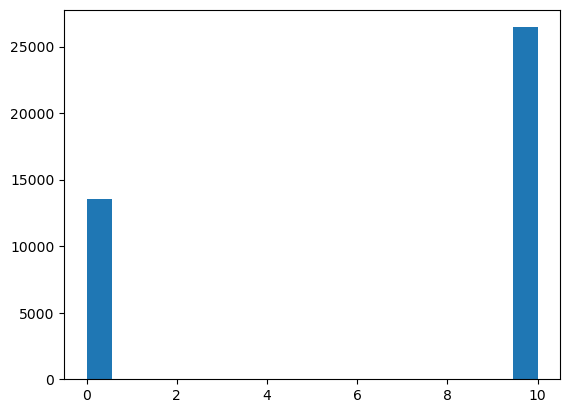